# 用神经网络来预测共享单车的数量
共享单车的投放很明显与许多因素有关系，地理位置、时间、天气等等。

作为多个输入、一个输出，线性回归的直线很明显不满足这个要求，所以我们选择使用神经网络来进行建模

具体的数据集在下面的网站下载 https://s3.amazonaws.com/capitalbikeshare-data/index.html

我下载的是 202312-capitalbikeshare-tripdata，但很明显这个已经有了具体站点的概念，适合别的分类和深度学习框架

所以我还是选择2011年的 这个将作为我下面内容的数据集

In [1]:
#导入需要使用的库
import numpy as np
import pandas as pd #读取csv文件的库
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

# 让输出的图形直接在Notebook中显示
%matplotlib inline

In [2]:
# 我想试试GPU来运行，CPU会占的很满
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 一、准备工作：读入数据文件

首先，我们读入数据，绘制图形，看看数据长成什么样子

In [3]:
#读取数据到内存中，rides为一个dataframe对象
data_path = 'hour.csv'
rides = pd.read_csv(data_path)

#看看数据长什么样子
rides.head()  #只展示前五行内容

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


数据介绍：特征因素（例如：年份，季度，星期几，温度，风速等因素）；目标变量（用户数，临时注册用户数，注册用户数）


很明显，单车的使用数量并不依赖于下标，而是依赖诸如天气、风俗、星期几和是否是节假日等模式，如果我们只是单纯的一个变量来预测，就会导致很严重的过拟合，没有发掘出数据真实的情况。

## 二、 介绍一下神经网络

人工神经网络是一种受人脑的生物神经网络启发而设计的计算模型，非常擅长从输入的数据和标签中学习映射关系，从而完成预测或者分类关系。

人工神经网络也称通用拟合器，因为它可以拟合任意的函数或映射

前馈神经网络是最常用的一种网络，它一般包含3层人工神经元，即输入层、隐含层和输出层。其中隐含层可以包含多层，神经元的连接旁都有一个数值叫做权重，通常用$w$来表示  
1. 在前馈的预测过程中，信号从输入单元输入，并沿着网络连边传输，每个信号会与连边上的权重进行乘积，从而得到隐含单元的输入；
2. 接下来，隐含单元对所有连边输入的信号进行汇总（求和），然后经过一定的处理（具体处理过程将在下一节讲述）后输出；
3. 这些输出的信号再乘以从隐含层到输出的那组连线上的权重，从而得到输入给输出单元的信号；
4. 最后，输出单元对每一条输入连边的信号进行汇总，加工处理后输出。最后的输出就是整个神经网络的输出。神经网络在训练阶段将会调节每条连边上的权重的数值。

所以我们需要将所有的相关信息都输入进去，从而预测单车的数量

## 三、 数据的处理

### 3.1 数据的预处理过程

在动手设计网络之前，需要增强对数据的了解 

我们可以发现，所有的变量可以分为两种：一种是类型变量，另一种是类型变量

所谓的类型变量，是指这个变量可以在不同的类别中取值，例如星期(week)这个变量就有1, 2, 3, …, 0这几种类型，分别代表星期一、星期二、星期三……星期日这几天。而天气状况(weathersit)这个变量可以从1~4中取值，其中1表示晴天，2表示多云，3表示小雨/雪，4表示大雨/雪。


另一种类型是数值类型，这种变量会从一个数值区间中连续取值。例如，湿度(humidity)就是一个从[0, 1]区间中连续取值的变量。温度、风速也是这种类型的变量。

#### a. 对于类型变量的处理

在类型变量中，数字的大小实际上没有任何意义。比如季节这个变量可以等于1、2、3、4，即四季，数字仅仅是对它们的区分。我们不能将season变量直接输入神经网络，因为season数值并不表示相应的信号强度，我们的解决方案是将类型变量转化为“独热编码”
$
season = 1 \rightarrow (1, 0, 0 ,0) \\
season = 2 \rightarrow (0, 1, 0, 0) \\
season = 3 \rightarrow (0, 0, 1, 0) \\
season = 4 \rightarrow (0, 0, 0, 1) \\
$

因此，如果一个类型变量有n个不同取值，那么我们的“一位热码“所对应的向量长度就为n

In [4]:
#对于类型变量的特殊处理
# season=1,2,3,4, weathersi=1,2,3, mnth= 1,2,...,12, hr=0,1, ...,23, weekday=0,1,...,6
# 经过下面的处理后，将会多出若干特征，例如，对于season变量就会有 season_1, season_2, season_3, season_4
# 这四种不同的特征。
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    #利用pandas对象，我们可以很方便地将一个类型变量属性进行one-hot编码，变成多个属性
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# 把原有的类型变量对应的特征去掉，将一些不相关的特征去掉
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,True,False,...,False,False,False,False,False,False,False,False,False,True
1,0,0,0.22,0.80,0.0,8,32,40,True,False,...,False,False,False,False,False,False,False,False,False,True
2,0,0,0.22,0.80,0.0,5,27,32,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0.24,0.75,0.0,3,10,13,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0,0,0.24,0.75,0.0,0,1,1,True,False,...,False,False,False,False,False,False,False,False,False,True


#### b. 对于数值类型变量进行标准化
由于每个数值型变量都是相互独立的，所以它们的数值绝对大小与问题本身没有关系，为了消除数值大小的差异，我们对每一个数值型变量进行标准化处理，也就是让其数值都围绕着0左右波动。比如，对于温度temp这个变量来说，它在整个数据库取值的平均着为mean(temp), 方差为std(temp)，所以，归一化的温度计算为：

$ temp'=\frac{temp - mean(temp)}{std(temp)}$

这样做的好处就是可以将不同的取值范围的变量设置为让它们处于一个平等的地位。

In [5]:
# 调整所有的特征，标准化处理
quant_features = ['cnt', 'temp', 'hum', 'windspeed']

# 我们将每一个变量的均值和方差都存储到scaled_features变量中。
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [6]:
print(data['temp'][0])

-1.3346091869412822


In [7]:
rides['temp'][:10]

0    0.24
1    0.22
2    0.22
3    0.24
4    0.24
5    0.24
6    0.22
7    0.20
8    0.24
9    0.32
Name: temp, dtype: float64

#### c. 将数据集进行分割

In [8]:
# 将所有的数据集分为测试集和训练集，我们以后21天数据一共21*24个数据点作为测试集，其它是训练集
test_data = data[-21*24:]
train_data = data[:-21*24]
print('训练数据：',len(train_data),'测试数据：',len(test_data))

# 将我们的数据列分为特征列和目标列

#目标列
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]  #drop将特征变量和目标变量分隔开
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据从pandas dataframe转换为numpy
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1])
losses = []

训练数据： 16875 测试数据： 504


In [9]:
features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,0,0,-1.438475,0.895513,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,0,0,-1.438475,0.895513,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,0,0,-1.334609,0.636351,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,0,0,-1.334609,0.636351,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


我们相当于使用56个特征变量 来预测一个输出变量

### 3.2 构建神经网络并进行训练（CPU）

#### a. 手动编写用Tensor运算的人工神经网络

In [11]:
# 定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1]  # 输入层单元个数
hidden_size = 10  # 隐含层单元个数
output_size = 1  # 输出层单元个数
batch_size = 128  # 每隔batch的记录数
weights1 = torch.randn([input_size, hidden_size], dtype=torch.double, requires_grad=True)  # 第一到二层权重
biases1 = torch.randn([hidden_size], dtype=torch.double, requires_grad=True)  # 隐含层偏置
weights2 = torch.randn([hidden_size, output_size], dtype=torch.double, requires_grad=True)  # 隐含层到输出层权重


def neu(x):
    # 计算隐含层输出
    # x为batch_size * input_size的矩阵，weights1为input_size*hidden_size矩阵，
    # biases为hidden_size向量，输出为batch_size * hidden_size矩阵

    # Convert x to double
    x_double = x.double()

    # Convert weights1 and biases1 to double before calculations
    weights1_double = weights1.double()
    biases1_double = biases1.double()

    # Calculate hidden layer output
    hidden = x_double.mm(weights1_double) + biases1_double.expand(x.size()[0], hidden_size)
    hidden = torch.sigmoid(hidden)

    # 输入batch_size * hidden_size矩阵，mm上weights2, hidden_size*output_size矩阵，
    # 输出batch_size*output_size矩阵
    output = hidden.mm(weights2)
    return output


def cost(x, y):
    # 计算损失函数
    error = torch.mean((x - y) ** 2)
    return error


def zero_grad():
    # 清空每个参数的梯度信息
    if weights1.grad is not None and biases1.grad is not None and weights2.grad is not None:
        weights1.grad.data.zero_()
        weights2.grad.data.zero_()
        biases1.grad.data.zero_()


def optimizer_step(learning_rate):
    # 梯度下降算法
    weights1.data.add_(- learning_rate * weights1.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases1.data.add_(- learning_rate * biases1.grad.data)



In [12]:
# 神经网络训练循环
losses = []
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一批一批地读取
    batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end].astype(np.float64), dtype=torch.double, requires_grad=True)
        yy = torch.tensor(Y[start:end].astype(np.float64), dtype=torch.double, requires_grad=True)
        predict = neu(xx)
        loss = cost(predict, yy)
        zero_grad()
        loss.backward()
        optimizer_step(0.01)
        batch_loss.append(loss.data.numpy())

    # 每隔100步输出一下损失值（loss）
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))


0 1.8072300191322255
100 0.5039922915727508
200 0.29949215679902214
300 0.25409522822632113
400 0.22990867231750306
500 0.2106120383103823
600 0.19309037054090822
700 0.17539535752097268
800 0.15575211886242812
900 0.13598163507360433


Text(0, 0.5, 'MSE')

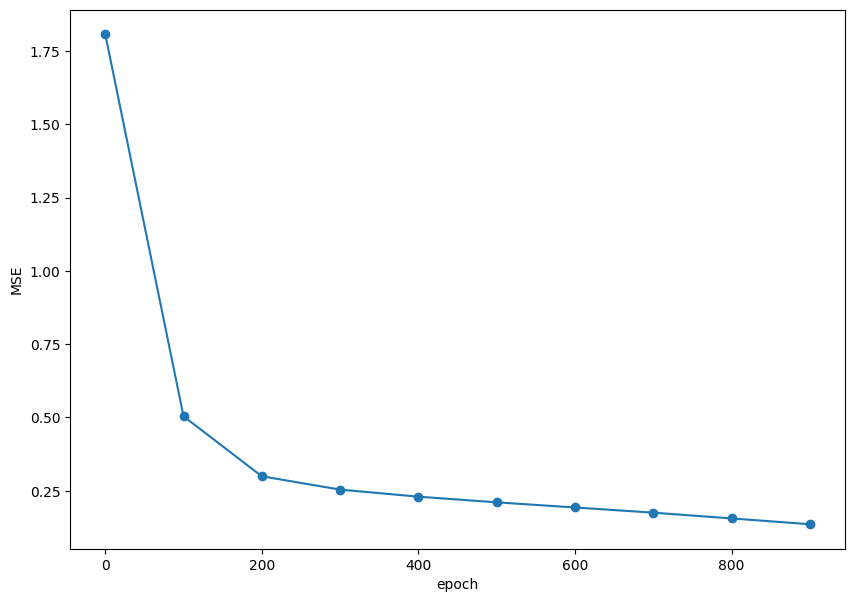

In [13]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

#### b. 调用PyTorch现成的函数，构建序列化的神经网络（GPU）

In [10]:
# 定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
).cuda()
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)

In [21]:
# 神经网络训练循环
losses = []
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一批一批地读取
    batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end].astype(np.float64), dtype=torch.float, requires_grad=True).cuda()
        yy = torch.tensor(Y[start:end].astype(np.float64), dtype=torch.float, requires_grad=True).cuda()
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.cpu().numpy())

    # 每隔100步输出一下损失值（loss）
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 0.06284873
100 0.061423108
200 0.060220633
300 0.059269473
400 0.058519945
500 0.057912942
600 0.057406843
700 0.056973286
800 0.056592144
900 0.056249075


Text(0, 0.5, 'MSE')

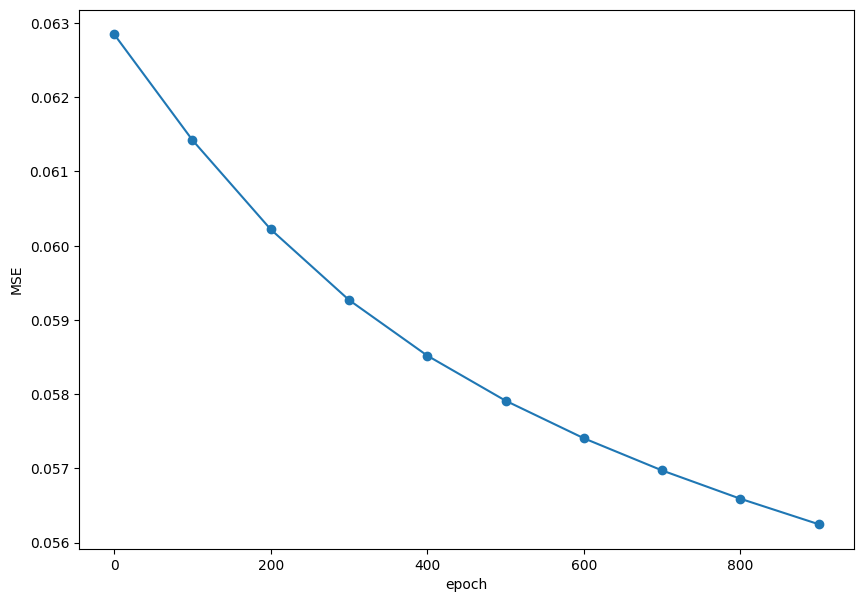

In [22]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

### 3. 测试神经网络

我们可以用训练好的神经网络在测试集上进行预测，并且将后21天的预测数据与真实数据画在一起进行比较

tensor([[ 1.0000,  0.0000,  0.0156,  0.9992,  0.2763,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000, -0.1921,  1.3102,  0.5199,  0.0000,  0.0000,  0.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, 

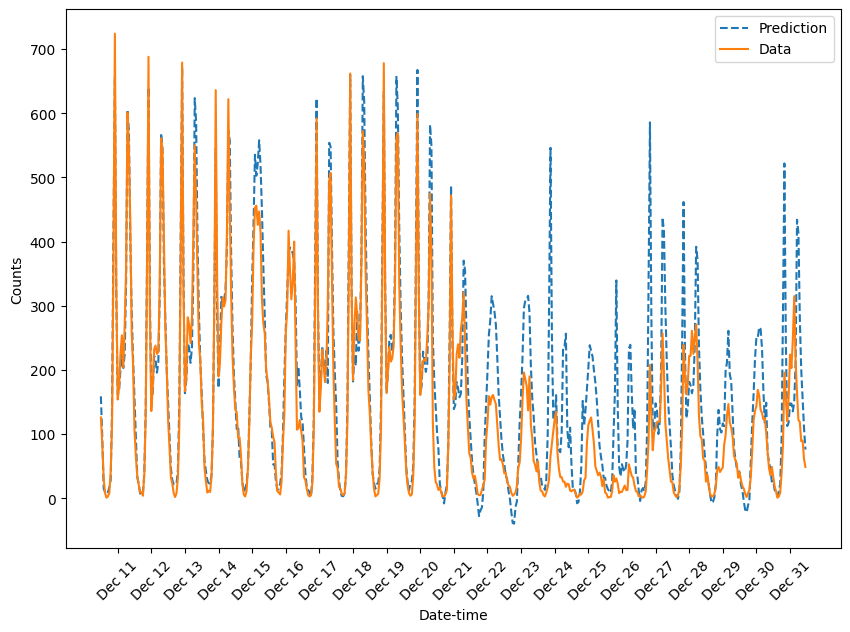

In [23]:
# 用训练好的神经网络在测试集上进行预测
targets = test_targets['cnt'] #读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1]) #将数据转换成合适的tensor形式
targets = targets.astype(float) #保证数据为实数

x = torch.tensor(test_features.values.astype(np.float64), dtype = torch.float, requires_grad = True).cuda()
y = torch.tensor(targets.astype(np.float64), dtype = torch.float, requires_grad = True).cuda()

print(x[:10])
# 用神经网络进行预测
predict = neu(x)
predict = predict.data.cpu().numpy()

print((predict * std + mean)[:10])


# 将后21天的预测数据与真实数据画在一起并比较
# 横坐标轴是不同的日期，纵坐标轴是预测或者真实数据的值
fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction', linestyle = '--')
ax.plot(targets * std + mean, label='Data', linestyle = '-')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [24]:
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)
plt.show()

图中，横坐标是不同的日期，纵坐标是预测或真实数据的值，虚线为预测曲线，实线位实际数据

可以看到，绝大多数的曲线是基本吻合的，只有在12月25日前后几天的实际值和预测值偏差较大，这是圣诞节前后，人们的出行习惯会与往日大为不同。

在我们的训练样本中，因为整个数据仅有两年的长度，所以包含圣诞节前后的样本仅有一次，导致无法很好的预测

### 4. 诊断网络*

我们想对训练好的神经网络进行剖析，看看为什么在某些数据上表达不佳。

对于我们来说，神经网络在训练的时候发生了什么完全是黑箱，但实际权重其实是可以提取出来分析的

In [68]:
def feature(X, net):
    # 定义了一个函数可以提取网络的权重信息，所有的网络参数信息全部存储在了neu的named_parameters集合中了
    X = torch.tensor(X.astype(np.float64), dtype = torch.float, requires_grad = False)
    dic = dict(net.named_parameters()) #提取出来这个集合
    weights = dic['0.weight'] #可以按照层数.名称来索引集合中的相应参数值
    biases = dic['0.bias'] #可以按照层数.名称来索引集合中的相应参数值
    h = torch.sigmoid(X.mm(weights.t()) + biases.expand([len(X), len(biases)])) # 隐含层的计算过程
    return h # 输出层的计算

在这段代码中，我们用net.named_parameters()命令提取出神经网络的所有参数，其中包括了每一层的权重和偏置，并且把它们放到Python字典中。接下来就可以通过如上代码来提取数据，例如可以通过dic['0.weight']和dic['0.bias']的方式得到第一层的所有权重和偏置。此外，我们还可以通过遍历参数字典dic获取所有可提取的参数名称。

由于数据量较大，因此我们选取了一部分数据输入神经网络，并提取网络的激活模式。我们知道，预测不准的日期有12月22日、12月23日、12月24日这3天。所以，就将这3天的数据聚集到一起，存入subset和subtargets变量中：

In [103]:
# 选出三天预测不准的日期：Dec 22，23，24
# 将这三天的数据聚集到一起，存入subset和subtargets中
bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'

# 将三个布尔型数组求与
bools = [any(tup) for tup in zip(bool1,bool2,bool3) ]
# 将相应的变量取出来
subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets),1])

将这3天的数据输入神经网络中，用前面定义的feature()函数读出隐含神经元的激活数值，存入results中。为了方便阅读，可以将归一化输出的预测值还原为原始数据的数值范围。

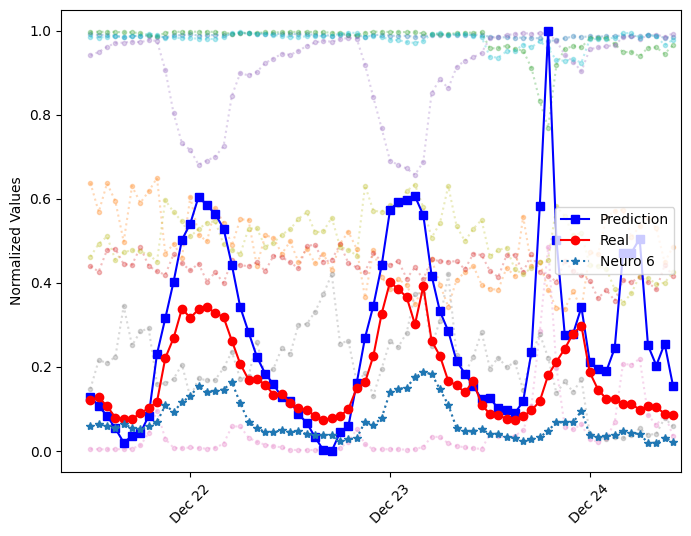

In [104]:

# # 将这几天的数据输入到神经网络中，读取出隐含层神经元的激活数值，存入results中
results = feature(subset.values, neu).data.numpy()



# 将 subset 的值移到 CPU 上进行预测
subset_tensor = torch.tensor(subset.values.astype(np.float64), dtype=torch.float, device='cpu', requires_grad=True)

# 将神经网络移到 CPU 上进行预测
neu_cpu = neu.to('cpu')

# 在 CPU 上进行预测
predict = neu_cpu(subset_tensor).data.numpy()



#将预测值还原成原始数据的数值范围
mean, std = scaled_features['cnt']
predict = predict * std + mean
subtargets = subtargets * std + mean
# 将所有的神经元激活水平画在同一张图上，蓝色的是模型预测的数值
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(results[:,:],'.:',alpha = 0.3)
ax.plot((predict - min(predict)) / (max(predict) - min(predict)),'bs-',label='Prediction')
ax.plot((subtargets - min(predict)) / (max(predict) - min(predict)),'ro-',label='Real')
ax.plot(results[:, 5],':*',alpha=1, label='Neuro 6')

ax.set_xlim(right=len(predict))
ax.legend()
plt.ylabel('Normalized Values')

dates = pd.to_datetime(rides.loc[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

图中方块曲线是模型的预测值，圆点曲线是实际值，不同颜色和线型的虚线是每个神经元的输出值。可以发现，Neuro 6的输出曲线与真实输出曲线比较接近。因此，我们可以认为该神经元对提高预测准确性有更大的贡献。

同时，我们还想知道Neuro 8为什么表现较好以及它的激活是由谁决定的。进一步分析它的影响因素，发现影响大小是通过输入层指向它的权重来判断的。

本题中输入神经元56个。

Text(0, 0.5, 'Weight')

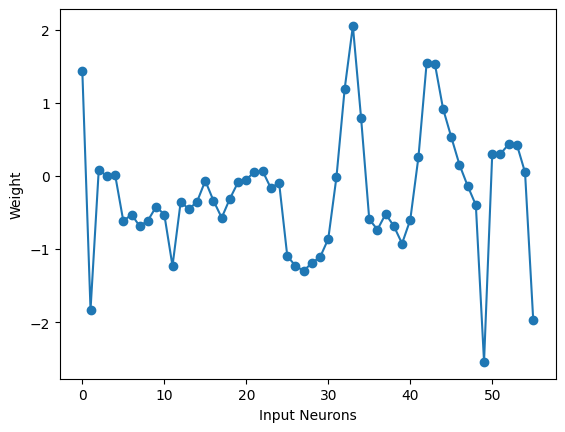

In [102]:
# 找到了与峰值响应的神经元，把它到输入层的权重输出出来
dic = dict(neu.named_parameters())
weights = dic['0.weight']
plt.plot(weights.data.numpy()[6,:],'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')

横轴代表不同的权重，也就是输入神经元的编号；纵轴代表神经网络训练后的连边权重。例如，横轴的第10个数对应输入层的第10个神经元，对应到输入数据中，是检测天气类别的类型变量。第32个数是小时数，也是类型变量，检测的是早6点这种模式。我们可以将其理解为，纵轴的值为正就是促进，值为负就是抑制

In [47]:
# 列出所有的features中的数据列，找到对应的编号
for (i, c) in zip(range(len(features.columns)), features.columns):
    print(i,c)

0 yr
1 holiday
2 temp
3 hum
4 windspeed
5 season_1
6 season_2
7 season_3
8 season_4
9 weathersit_1
10 weathersit_2
11 weathersit_3
12 weathersit_4
13 mnth_1
14 mnth_2
15 mnth_3
16 mnth_4
17 mnth_5
18 mnth_6
19 mnth_7
20 mnth_8
21 mnth_9
22 mnth_10
23 mnth_11
24 mnth_12
25 hr_0
26 hr_1
27 hr_2
28 hr_3
29 hr_4
30 hr_5
31 hr_6
32 hr_7
33 hr_8
34 hr_9
35 hr_10
36 hr_11
37 hr_12
38 hr_13
39 hr_14
40 hr_15
41 hr_16
42 hr_17
43 hr_18
44 hr_19
45 hr_20
46 hr_21
47 hr_22
48 hr_23
49 weekday_0
50 weekday_1
51 weekday_2
52 weekday_3
53 weekday_4
54 weekday_5
55 weekday_6


可以看出曲线在hr_9和hr_18、hr_19方面有较高的权重，满足这些条件，这个Neuro 6就会被激活。同理在负值的因子就会被抑制。 

2012年的12月22日和23日刚好是周六和周日，因此Neuro 6被激活了，它们对正确预测这两天的正午高峰做了贡献。但是，由于圣诞节即将到来，人们可能早早回去为圣诞做准备，因此这个周末比较特殊，并未出现往常周末的大量骑行需求，于是Neuro 6给出的激活值导致了正午单车预测值过高。


如果想分析别的神经元也是同样的道理，总的来说神经预测器在这3天预测不准的原因是圣诞假期的反常模式，如果有更多的训练数据，我们可以将异常神经元的权重调节低一点，这样可以提高预测的准确率。